In [1]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.4 MB/s eta 0:00:00


In [2]:
import os
import requests
import zipfile
import glob
from dataclasses import dataclass, fields

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt


In [3]:
def system_config(SEED_VALUE):
  random.seed(SEED_VALUE)
  tf.keras.utils.set_random_seed(SEED_VALUE)
  os.environ["CUDA_VISIBLE_DEVICES"] = "0"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
  os.environ["TF_USE_CUDNN"] = "true"

system_config(SEED_VALUE=42)

In [4]:
!pip install kaggle
!kaggle datasets download -d qrsforever/welding-spots-100


Dataset URL: https://www.kaggle.com/datasets/qrsforever/welding-spots-100
License(s): apache-2.0
 50% 5.00M/9.98M [00:00<00:00, 36.2MB/s]
100% 9.98M/9.98M [00:00<00:00, 66.7MB/s]


In [5]:
!unzip welding-spots-100.zip

Archive:  welding-spots-100.zip
  inflating: welding_spots/image/001.jpg  
  inflating: welding_spots/image/002.jpg  
  inflating: welding_spots/image/003.jpg  
  inflating: welding_spots/image/004.jpg  
  inflating: welding_spots/image/005.jpg  
  inflating: welding_spots/image/006.jpg  
  inflating: welding_spots/image/007.jpg  
  inflating: welding_spots/image/008.jpg  
  inflating: welding_spots/image/009.jpg  
  inflating: welding_spots/image/010.jpg  
  inflating: welding_spots/image/011.jpg  
  inflating: welding_spots/image/012.jpg  
  inflating: welding_spots/image/013.jpg  
  inflating: welding_spots/image/014.jpg  
  inflating: welding_spots/image/015.jpg  
  inflating: welding_spots/image/016.jpg  
  inflating: welding_spots/image/017.jpg  
  inflating: welding_spots/image/018.jpg  
  inflating: welding_spots/image/019.jpg  
  inflating: welding_spots/image/020.jpg  
  inflating: welding_spots/image/021.jpg  
  inflating: welding_spots/image/022.jpg  
  inflating: welding_s

In [6]:
import os

img_dir = "welding_spots/image"
mask_dir = "welding_spots/mask"

print("Total images:", len(os.listdir(img_dir)))
print("Total masks:", len(os.listdir(mask_dir)))


Total images: 100
Total masks: 100


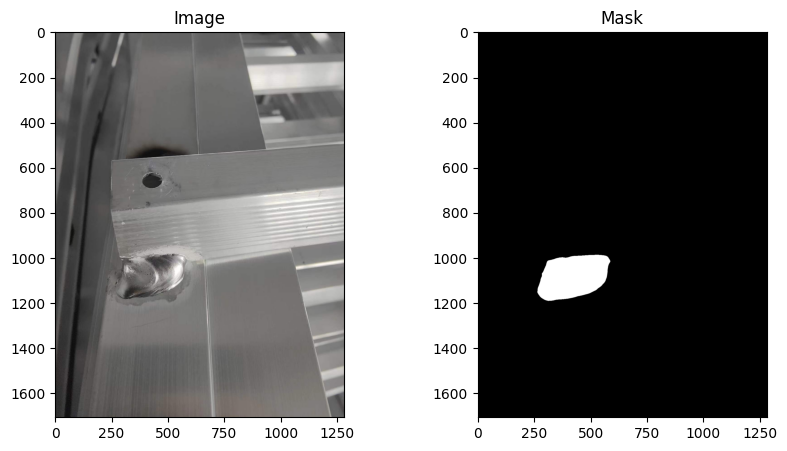

In [7]:
import cv2
import matplotlib.pyplot as plt

img_path = "welding_spots/image/001.jpg"
mask_path = "welding_spots/mask/001.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title("Image")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
plt.show()


#Configs

In [8]:
@dataclass(frozen=True)
class DatasetConfig:
  IMAGE_SIZE:         tuple = (256,256)
  BATCH_SIZE:         int = 16
  NUM_CLASSES:        int = 2
  BRIGHTNESS_FACTOR:  float = 0.2
  CONTRAST_FACTOR:    float = 0.2


#freeze

In [9]:
@dataclass(frozen=True)
class TrainingConfig:
  MODEL:              str = "resnet50_v2_imagenet"
  EPOCHS:             int = 25
  LEARNING_RATE:      float = 1e-4
  CKPT_DIR:           str = os.path.join("checkpoints",
                                         "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
  LOGS_DIR:           str = os.path.join("logs_"+"_".join(MODEL.split("_")[:2]))


In [10]:
train_config = TrainingConfig()
dataset_config = DatasetConfig()

#Dataset preparation


In [11]:
data_images = glob.glob("welding_spots/image/*.jpg")
data_masks = glob.glob("welding_spots/mask/*.png")

zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [12]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))


#Train-Valid split


In [13]:
#95-5ratio
SPLIT_RATIO = 0.05
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

print(len(train_data))
print(len(valid_data))

95
5


In [14]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 95
Validation samples: 5


#Threshold masks


In [15]:
def read_image_mask(image_path, mask=False, size=dataset_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(image, size, method="bicubic")
        image.set_shape([size[0], size[1], 1])  # Ensure correct shape

        print(f"Max mask value before thresholding: {tf.reduce_max(image)}")  # Debugging

        image_mask = tf.zeros_like(image)
        cond = image >= 150  # Lower threshold from 200 to 150
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, size, method="bicubic")
        image.set_shape([size[0], size[1], 3])  # Ensure correct shape
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image


In [16]:
def load_data(image_list, mask_list):

  image = read_image_mask(image_list)
  mask = read_image_mask(mask_list, mask=True)
  return {"images": image, "segmentation_masks":mask}

In [17]:
train_data = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

Max mask value before thresholding: Tensor("Max:0", shape=(), dtype=float32)
Max mask value before thresholding: Tensor("Max:0", shape=(), dtype=float32)


#unpack images and segmentation masks


In [18]:
def unpackage_inputs(inputs):
  images = inputs["images"]
  segmentation_masks = inputs["segmentation_masks"]
  return images, segmentation_masks

In [19]:
for inputs in train_data.take(1):
    img, mask = unpackage_inputs(inputs)  # Unpack the dictionary
    print(f"Image shape: {img.shape}, dtype: {img.dtype}")
    print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
    unique_values = tf.unique(tf.reshape(mask, [-1]))[0]
    print(f"Unique mask values: {unique_values.numpy()}")

Image shape: (256, 256, 3), dtype: <dtype: 'float32'>
Mask shape: (256, 256, 1), dtype: <dtype: 'uint8'>
Unique mask values: [0 1]


#Ground truth visulas


In [20]:
id2color = {
    0: [0, 0, 0], #background
    1: [102, 240, 255] #weld
}

In [21]:
#1channel to RGB
def num_to_rgb(num_arr, color_map=id2color):

  output = np.zeros(num_arr.shape[:2]+(3,))

  for k in color_map.keys():
    output[num_arr==k] = color_map[k]

  return output.astype(np.uint8)




In [22]:
def image_overlay(image, segmented_image):

  alpha = 1.0
  beta = 0.7
  gamma = 0.0

  image = image.astype(np.uint8)

  segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

In [23]:
import matplotlib.pyplot as plt

def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    # Check if predicted mask exists and convert to RGB
    if len(data_list) == 3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # Create overlayed image
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    data_list.append(overlayed_image)

    title_list.append("Overlayed Image")
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])

        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
        else:
            axis.imshow(data_list[idx])

        axis.axis("off")

    plt.tight_layout()
    plt.show()


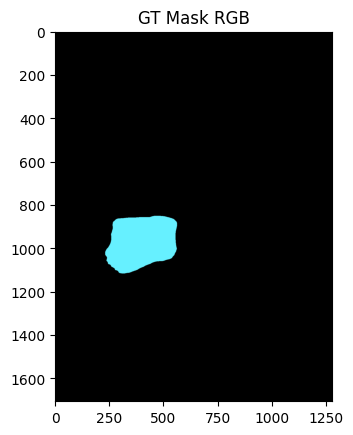

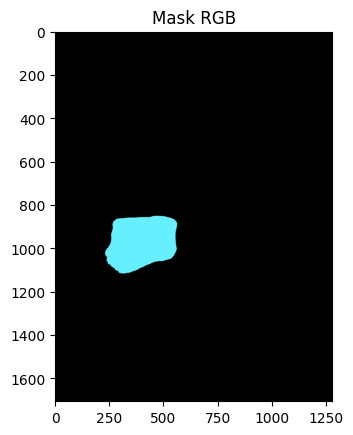

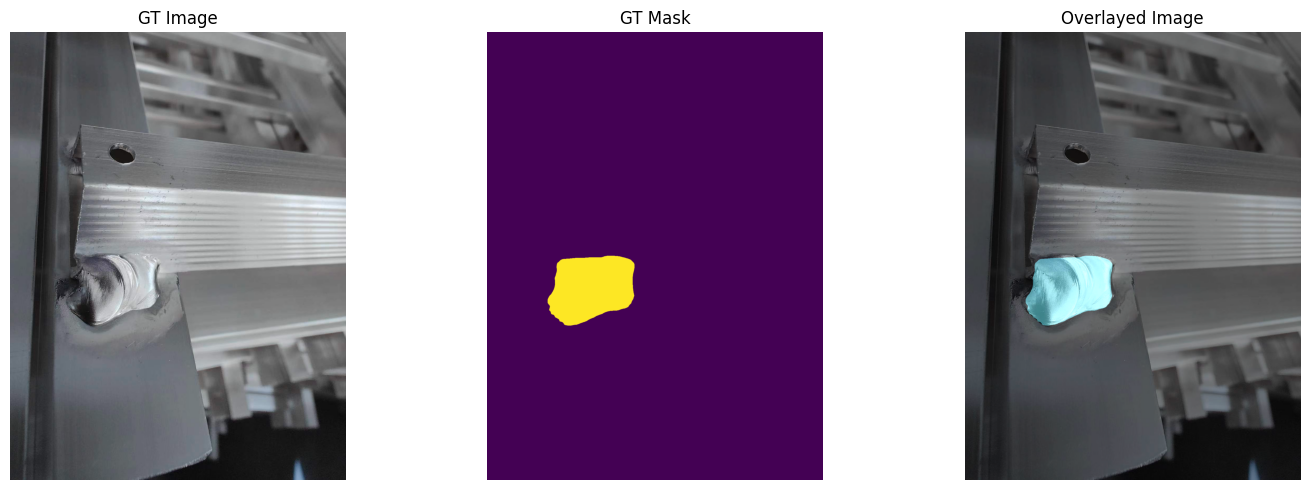

In [27]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

id2color = {
    0: [0, 0, 0],
    1: [102, 240, 255]
}

def num_to_rgb(num_arr, color_map=id2color):
    """
    Converts a numerical mask array into an RGB mask using the color map provided.
    """
    output = np.zeros(num_arr.shape[:2] + (3,), dtype=np.uint8)
    for k in color_map.keys():
        output[num_arr == k] = color_map[k]
    return output

def image_overlay(image, mask, alpha=0.6, beta=0.4, gamma=0):
    """
    Overlay the mask on the image using alpha blending.
    """
    # Convert the mask to RGB using the provided color_map
    mask_rgb = num_to_rgb(mask)

    # Debug: Check the mask image itself
    plt.imshow(mask_rgb)
    plt.title("Mask RGB")
    plt.show()

    # Perform alpha blending
    overlayed_image = cv2.addWeighted(image, alpha, mask_rgb, beta, gamma)

    return overlayed_image

def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])

        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(data_list[1])
            else:
                axis.imshow(data_list[1], cmap="gray")
        elif title_list[idx] == "Overlayed Image":
            axis.imshow(data_list[idx])
        else:
            axis.imshow(data_list[idx])

        axis.axis("off")

    plt.tight_layout()
    plt.show()

def display_gt_and_overlayed_image(gt_image, gt_mask, color_map=id2color, figsize=(15, 5)):

    _, gt_mask = cv2.threshold(gt_mask, 1, 255, cv2.THRESH_BINARY)

    gt_mask = gt_mask.astype(np.uint8) // 255  # Normalize to binary (0,1)
    rgb_gt_mask = num_to_rgb(gt_mask, color_map=color_map)

    plt.imshow(rgb_gt_mask)
    plt.title("GT Mask RGB")
    plt.show()

    # Create the overlayed image with a stronger mask effect
    overlayed_image = image_overlay(gt_image, gt_mask, alpha=0.7, beta=0.5)


    data_list = [gt_image, gt_mask, overlayed_image]
    title_list = ["GT Image", "GT Mask", "Overlayed Image"]
    display_image_and_mask(data_list, title_list, figsize, color_mask=True, color_map=color_map)

# Example
gt_image = cv2.imread('/content/welding_spots/image/056.jpg')
gt_mask = cv2.imread('/content/welding_spots/mask/056.png', cv2.IMREAD_GRAYSCALE)


#gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)
#gt_mask = gt_mask.astype(np.uint8)
display_gt_and_overlayed_image(gt_image, gt_mask)


#Data Augmentation

In [28]:
augment_fn = tf.keras.Sequential(
    [
    keras_cv.layers.RandomFlip(),
    keras_cv.layers.RandomBrightness(factor=dataset_config.BRIGHTNESS_FACTOR, value_range=(0, 255)),
    keras_cv.layers.RandomContrast(factor=dataset_config.CONTRAST_FACTOR, value_range=(0, 255)),
    ])

In [29]:
train_data = (
    train_data.shuffle(dataset_config.BATCH_SIZE)
    .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(dataset_config.BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_data = (
    valid_data.batch(dataset_config.BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

#visualize augmented data


Mask 0 unique values: [0 1]
Image 0 shape: (256, 256, 3), Mask 0 shape: (256, 256)


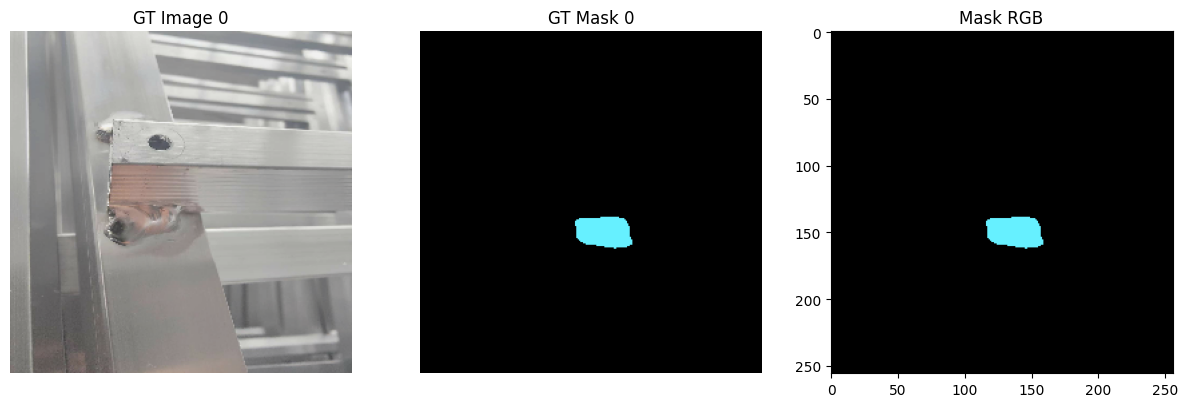

<Figure size 640x480 with 0 Axes>

Mask 1 unique values: [0 1]
Image 1 shape: (256, 256, 3), Mask 1 shape: (256, 256)


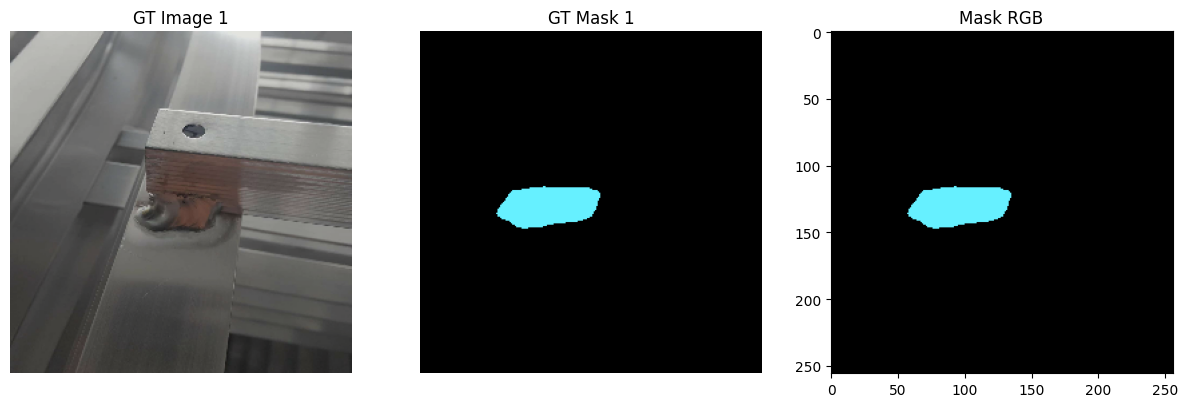

<Figure size 640x480 with 0 Axes>

Mask 2 unique values: [0 1]
Image 2 shape: (256, 256, 3), Mask 2 shape: (256, 256)


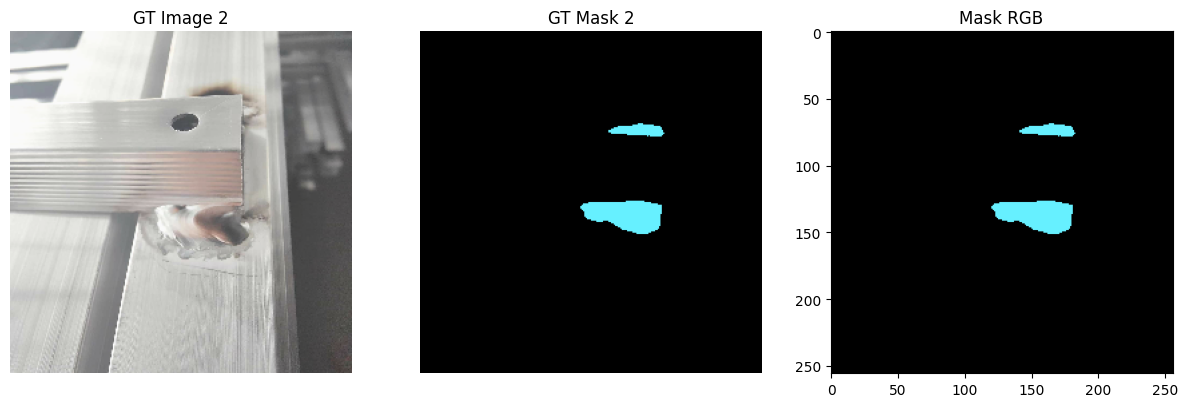

<Figure size 640x480 with 0 Axes>

In [30]:
def display_augmented_images(augmented_images, augmented_masks, num_images=3):

    for i in range(min(num_images, len(augmented_images))):
        # Get the i-th image and mask from the batch
        image = augmented_images[i].numpy().astype(np.uint8)  # Convert tensor to numpy array
        mask = augmented_masks[i].numpy().astype(np.uint8)

        if len(mask.shape) == 3:
            mask = np.squeeze(mask, axis=-1)  #  (make it 2D)

        print(f"Mask {i} unique values: {np.unique(mask)}")
        print(f"Image {i} shape: {image.shape}, Mask {i} shape: {mask.shape}")

        # Check if there are any empty or invalid masks
        if np.all(mask == 0):
            print(f"Warning: Mask {i} is empty (all zeros).")

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display GT Image
        axes[0].imshow(image)
        axes[0].set_title(f"GT Image {i}")
        axes[0].axis('off')

        # Display GT Mask (in RGB)
        rgb_mask = num_to_rgb(mask)
        axes[1].imshow(rgb_mask)
        axes[1].set_title(f"GT Mask {i}")
        axes[1].axis('off')

        # Overlayed Image
        overlayed_image = image_overlay(image, mask)
        axes[2].imshow(overlayed_image)
        axes[2].set_title(f"Overlayed Mask {i}")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

for augmented_images, augmented_masks in train_data.take(1):  # batch from the train data
    display_augmented_images(augmented_images, augmented_masks)


#model training


In [31]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                           input_shape = dataset_config.IMAGE_SIZE+(3,),
                                                           load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
    num_classes=dataset_config.NUM_CLASSES,
    backbone=backbone,

)

print(model.summary())

100%|██████████| 886/886 [00:00<00:00, 1.46MB/s]


100%|██████████| 90.3M/90.3M [00:02<00:00, 40.7MB/s]


Model: "deep_lab_v3_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 256),  │     23,556,608 │ input_layer[0][0]      │
│                           │ (None, 8, 8, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_pyramid_pooling   │ (None, 8, 8, 256)      │     15,538,176 │ functional[0][1]       │
│ (SpatialPyramidPooling)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output_upsampling │ (None, 64, 64, 256)    │              0 │ spatial_pyramid_pooli… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 64, 64, 48)     │         12,480 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 304)    │              0 │ encoder_output_upsamp… │
│                           │                        │                │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 256, 256, 2)    │         79,360 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,186,624 (149.49 MB)

 Trainable params: 39,141,600 (149.31 MB)

 Non-trainable params: 45,024 (175.88 KB)

None


Evaluation metrics


In [32]:
def mean_iou(y_true, y_pred):

  num_classes = y_pred.shape[-1]

  y_true = tf.squeeze(y_true, axis=-1)

  y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
  y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

  intersection = tf.math.reduce_sum(y_true * y_pred, axis=[1, 2])

  total = tf.math.reduce_sum(y_true, axis=[1, 2]) + tf.math.reduce_sum(y_pred, axis=[1, 2])

  union = total - intersection

  is_class_present = tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
  num_clasess_present = tf.math.reduce_sum(is_class_present, axis=1)

  iou = tf.math.divide_no_nan(intersection, union)
  iou = tf.reduce_sum(iou, axis=1) / num_clasess_present

  mean_iou = tf.math.reduce_mean(iou)

  return mean_iou


In [33]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )

    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

#Train model


In [34]:
callbacks = get_callbacks(train_config)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(
    optimizer = tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss = loss_fn,
    metrics = ["accuracy",mean_iou],
)



In [35]:
history = model.fit(
    train_data,
    epochs = train_config.EPOCHS,
    validation_data = valid_data,
    callbacks = callbacks,
)
model.save(train_config.CKPT_DIR)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8262 - loss: 0.4166 - mean_iou: 0.4305
Epoch 1: val_mean_iou improved from -inf to 0.48460, saving model to checkpoints/deeplabv3_plus_resnet50_v2.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.8300 - loss: 0.4123 - mean_iou: 0.4332 - val_accuracy: 0.9692 - val_loss: 0.1540 - val_mean_iou: 0.4846
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9356 - loss: 0.3007 - mean_iou: 0.5088
Epoch 2: val_mean_iou did not improve from 0.48460
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9364 - loss: 0.2992 - mean_iou: 0.5093 - val_accuracy: 0.9247 - val_loss: 0.2662 - val_mean_iou: 0.4629
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9649 - loss: 0.2481 - mean_iou: 0.5343
Epoch 3: val_mean_iou did not improve from 0.48460
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9653 - loss: 0.2469 - mean_iou: 0.5339 - val_accuracy: 0.4999 - val_loss: 0.9006 - val_mean_iou: 0.2633
Epoch 4/25
6/6 ━━━━━━━━━━━

#load finetunes weights


In [64]:
evalute = model.evaluate(valid_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9600 - loss: 0.2001 - mean_iou: 0.4900


In [65]:
for batch_img, batch_mask in valid_data.take(1):  # Get a single batch from the validation data

  batch_pred = model.predict(batch_img)
  batch_pred = np.argmax(batch_pred, axis=-1)  # Apply argmax to get predicted class indices

  print(f"Batch Image Shape: {batch_img.shape}")
  print(f"Model Output Shape Before Argmax: {model.predict(batch_img).shape}")
  print(f"Predicted Mask Shape After Argmax: {batch_pred.shape}")
  break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Batch Image Shape: (5, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Model Output Shape Before Argmax: (5, 256, 256, 2)
Predicted Mask Shape After Argmax: (5, 256, 256)


In [66]:
print(f"Pred Mask Unique Values: {np.unique(batch_pred)}")


Pred Mask Unique Values: [0 1]


In [67]:
import numpy as np
import matplotlib.pyplot as plt

def inference(model, dataset, samples_to_plot, threshold=0.2, temperature=0.5):
    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):
        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = model.predict(batch_img)  # Shape: (batch_size, 256, 256, num_classes)
        prob_class_1 = batch_pred[..., 1]
        prob_class_1_adjusted = np.exp(prob_class_1 / temperature) / np.sum(np.exp(batch_pred / temperature), axis=-1)

        # Apply thresholding to get binary mask
        batch_pred_bin = (prob_class_1_adjusted > threshold).astype(np.uint8)

        # Convert tensors to numpy arrays
        batch_img = batch_img.numpy().astype(np.uint8)
        batch_mask = batch_mask.numpy().squeeze(axis=-1)
        batch_pred_bin = batch_pred_bin.astype(np.uint8)  # Convert prediction to uint8

        print(f"Min prob for class 1: {np.min(prob_class_1)}")
        print(f"Max prob for class 1: {np.max(prob_class_1)}")
        print(f"Mean prob for class 1: {np.mean(prob_class_1)}")
        print(f"Pred Mask Unique Values: {np.unique(batch_pred_bin)}")

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred_bin):
            count += 1


            display_image_and_mask(
                [image, mask, pred],
                title_list=titles,
                figsize=(10, 10),
                color_mask=True
            )

            if count >= samples_to_plot:
                stop_plot = True
                break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


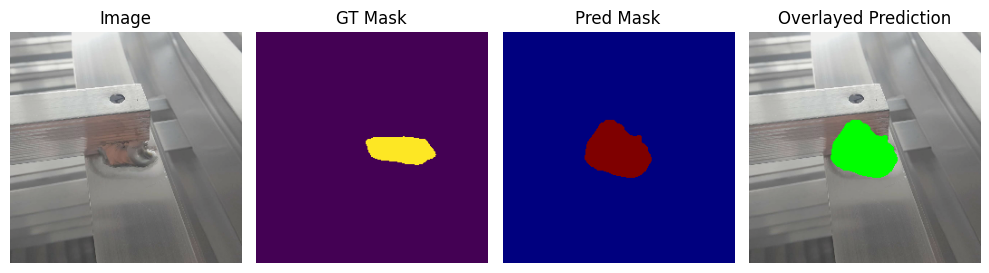

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def overlayed_image(image, pred_mask, num_classes=2):
    overlay = image.copy()

    if num_classes == 2:  # Binary segmentation
        overlay[pred_mask == 1] = [0, 255, 0]
    else:  # Multi-class segmentation
        for class_id in range(num_classes):
            overlay[pred_mask == class_id] = [0, 255 * (class_id + 1), 255 * (num_classes - class_id)]
    return overlay

# Function to display images, ground truth masks, predicted masks, and overlayed predictions
def display_image_and_mask(images, title_list, figsize=(10, 10), color_mask=True):
    fig, axes = plt.subplots(1, 4, figsize=figsize)

    for ax, img, title in zip(axes, images, title_list):
        ax.set_title(title)
        ax.axis("off")

        if color_mask:
            if len(img.shape) == 2:
                ax.imshow(img, cmap='jet')
            else:
                ax.imshow(img)
        else:
            ax.imshow(img)

    plt.tight_layout()
    plt.show()

def inference(model, dataset, samples_to_plot=5):
    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):
        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        print(f"Input image batch shape: {batch_img.shape}")
        print(f"Ground truth mask batch shape: {batch_mask.shape}")

        # Model prediction
        batch_pred = model.predict(batch_img)


        print(f"Predicted raw output shape: {batch_pred.shape}")
        print(f"Predicted unique values before processing: {np.unique(batch_pred)}")


        if batch_pred.shape[-1] == 1:
            batch_pred = (batch_pred > 0.2).astype(np.uint8)
        else:
            batch_pred = batch_pred.argmax(axis=-1)


        print(f"Predicted unique values after thresholding/argmax: {np.unique(batch_pred)}")


        batch_img = batch_img.numpy().astype(np.uint8)
        batch_mask = batch_mask.numpy().squeeze(axis=-1)
        batch_pred = batch_pred.astype(np.uint8)
        print(f"Pred Mask 0 unique values: {np.unique(batch_pred)}")


        if np.all(batch_pred == 0):
            print(f"Warning: Predicted mask contains only zeros!")


        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count += 1


            print(f"Mask Unique Values: {np.unique(mask)}")
            print(f"Pred Mask Unique Values: {np.unique(pred)}")

            # Display the results
            display_image_and_mask(
                [image, mask, pred, overlayed_image(image, pred)],
                title_list=titles,
                figsize=(10, 10),
                color_mask=True
            )

            if count >= samples_to_plot:
                stop_plot = True
                break

# visualize augmented images with predicted masks
for augmented_images, augmented_masks in train_data.take(1):
    predicted_masks = model.predict(augmented_images)


    if predicted_masks.shape[-1] == 1:
        predicted_masks = (predicted_masks > 0.5).astype(np.uint8)
    else:
        predicted_masks = np.argmax(predicted_masks, axis=-1)


    display_image_and_mask([augmented_images[0].numpy().astype(np.uint8), augmented_masks[0].numpy().astype(np.uint8), predicted_masks[0], overlayed_image(augmented_images[0].numpy().astype(np.uint8), predicted_masks[0])],
                           ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"])
